### Goals of this new version
- change units

## hide_toggle() setup

In [1]:
#Note that I don't actually know how this function works,
#but it doesn't really matter because I'm not looking to
#edit this function any time soon. It serves its purpose.

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

# Original Kendall Tau Setup

## g_new, L_lim1
```python
- g_new(z, k)
- L_lim1(F_lim, z_i, d_Li, g=g_new, k=0)
```
- edited for J -> erg change

In [2]:
def g_new(z, k): #The improved g-function, which transforms luminosities
    Z = z+1
    Z_c = 3.5
    return Z**k/(1+Z/Z_c)**k

def L_lim1(F_lim, z_i, d_Li, g=g_new, k=0): #finds the limiting luminosity using flux, luminosity distance, and g
    return (F_lim*1e-19)*4*math.pi*(d_Li*3.08567758e25)**2/g(z_i, k)

hide_toggle()

## sort_by_first, kt_newform + importing packages
- numpy as np, matplotlib as plt, math 
- functions:

```python 
- sort_by_first(A, B, reverse=False)
- sort_by_1(*args, reverse=False)
```
sort_by_1 is the more general function of the two; it can take multiple arguments

```python
- kt_newform(L, z, F_lim, d_L, g=g_new, k=0, func=L_lim1)
```
**- potential error with kendall_tau in removing those under limit** (should be resolved)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

def sort_by_first(A, B, reverse=False): #SORT USING Z!
    list1, list2 = zip(*sorted(zip(A, B), reverse=reverse))
    return list(list1), list(list2)

def sort_by_1(*args, reverse=False):
    thing = zip(*sorted(zip(*args), reverse=reverse))
    return [list(thang) for thang in thing]

def kt_newform(L, z, F_lim, d_L, g=g_new, k=0, func=L_lim1):
    
    #if necessary, sort by z while keeping reference to L
    z, L, d_L = sort_by_1(z, L, d_L)
        
    R = []
    E = []
    V = []
    
    for i in range(len(L)):
        higher = 0
        lower = 0
        
        # I have a lot of trouble with this line. Ex. when using kt on Parkes,
        # without this line the tau curve is smooth and goes through t=0 at k~2,
        # whereas using this line it is rough and goes through at k~5. I must
        # look into why this line is causing so much trouble and how to fix it.
        
        #It looks like some errors in other cells, not this cell.
        
        #not considering data points under the cutoff
        if(L[i] < func(F_lim, z[i], d_L[i], g=g, k=k)):
            continue
        
        for j in range(0, i): #since sorted by now, only j < i has z_j < z_i
            if(L[j] >= func(F_lim, z[i], d_L[i], g=g, k=k) and z[j] <= z[i]): #associated set requirements
                
                if(L[j] > L[i]):
                    higher += 1
                else:
                    lower += 1
        
        R.append((lower+1)/(higher+lower+1))
        E.append(0.5)
        V.append(1/12)
    
    numer = sum(R) - sum(E)
    denom = (sum(V))**0.5
    return numer/denom

hide_toggle()

## L_lim2, kendall_tau
```python
L_lim2(L_limi)
kendall_tau(L, Llim, srted=False, func=L_lim2)
```
- these functions are specifically for the L-Llim plots

In [4]:
#original setup of Kendall Tau, using a generic F_lim, z --> L converter
#now only used in L-Llim space, since cannot account for d_L

def L_lim2(L_limi):
    return L_limi

def kendall_tau(L, Llim, srted=False, func=L_lim2):
    
    #if necessary, sort by z while keeping reference to L
    
    #these days I almost always assume it isn't sorted
    #bc 1) if I assume it is sorted, trouble may ensue
    #and 2) it doesn't take too long to sort it again
    
    if not srted:
        Llim, L = sort_by_first(Llim, L)
        
    R = [] # rank
    E = [] # expected value
    V = [] # (expected) variance
    
    for i in range(len(L)):
        higher = 0
        lower = 0
        
        #similar issue?
        
        if(L[i] < func(Llim[i])): #don't include sources that are not above flux limit
            continue
        
        for j in range(0, i): #since sorted by now, only j < i has z_j < z_i
            if(L[j] >= func(Llim[i]) and Llim[j] <= Llim[i]): #associated set requirements
                if(L[j] > L[i]):
                    higher += 1
                else:
                    lower += 1
        
        R.append((lower+1)/(higher+lower+1))
        E.append(0.5)
        V.append(1/12)
    
    numer = sum(R) - sum(E)
    denom = (sum(V))**0.5
    return numer/denom

hide_toggle()

# Importing Data, Deriving Parameters
- `frb`: all the FRB id strings
- `telescope`: ASKAP, Parkes, or CHIME
- `snr`: signal to noise ratio (i think all the 0's are set to 6)
- `f_p`: peak flux, Jy
- `d_L`: luminosity distance, in Gpc
- `z`: redshift

In [5]:
import csv

frb, telescope, snr, f_p, d_L, z = [], [], [], [], [], []

with open('frb.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
            continue
        line_count += 1
        if float(row[2]) > 6:
            frb.append(row[0])
            telescope.append(row[1])
            snr.append(float(row[2]))
            f_p.append(float(row[3]))
            d_L.append(float(row[4]))
            z.append(float(row[5]))
        '''
        else: 
            frb.append(row[0])
            telescope.append(row[1])
            snr.append(6)
            f_p.append(float(row[3]))
            d_L.append(float(row[4]))
            z.append(float(row[5]))
        '''
    print(f'Processed {line_count} lines.')

hide_toggle()

Processed 64 lines.


- f_lim = limiting flux as defined as $F_p/(S/N)$
- L_p = peak luminosity, as defined as $F_p * 4 \pi d_L^2$
- L_plim = limiting peak luminosity, defined as $F_{lim} * 4 \pi d_L^2 = L_p/(S/N)$

**problem with erg/s versus W** (should be fixed, if not then bad)

In [6]:
#Deriving New Parameters
f_lim = []
L_p = []
L_plim = []

for i in range(len(f_p)):
    f_lim_i = f_p[i]/(snr[i])
    L_p_i = (f_p[i]*1e-19)*4*math.pi*(d_L[i]*3.08567758e25)**2
    L_plim_i = (f_lim_i*1e-19)*4*math.pi*(d_L[i]*3.08567758e25)**2
    f_lim.append(f_lim_i)
    L_p.append(L_p_i)
    L_plim.append(L_plim_i)

hide_toggle()

removing the uppercase Parkes

In [7]:
telescope = [telescope[i].lower() for i in range(len(telescope))] #removing the uppercase Parkes
set(telescope)

hide_toggle()

## Other Cell for DM and Fluence

In [8]:
frb_other, telescope_other, DM, W, snr_other, f_p_other = [], [], [], [], [], []

with open('DM_and_fluence.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
            continue
        line_count += 1
        if float(row[4]) > 6:
            frb_other.append(row[0])
            telescope_other.append(row[1])
            DM.append(float(row[2]))
            W.append(float(row[3]))
            snr_other.append(float(row[4]))
            f_p_other.append(float(row[5]))
    print(f'Processed {line_count} lines.')
    
hide_toggle()

Processed 64 lines.


just had slight issue with csvs not being consistent; fixing issue here
issues with i=27,28 switched

In [9]:
data27 = (frb_other[27], 'parkes', DM[27], W[27], snr_other[27], f_p_other[27])
data28 = (frb_other[28], 'parkes', DM[28], W[28], snr_other[28], f_p_other[29])
frb_other[27], telescope_other[27], DM[27], W[27], snr_other[27], f_p_other[27] = data28
frb_other[28], telescope_other[28], DM[28], W[28], snr_other[28], f_p_other[28] = data27
hide_toggle()

deriving fluence

In [10]:
fluence = [f_p[i] * W[i] for i in range(len(f_p))]
hide_toggle()

NameError: name 'ASKAP' is not defined

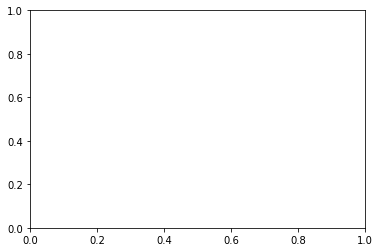

In [11]:
fig, ax = plt.subplots()
#ax.set_yscale('log')
#ax.set_xscale('log')

tel = ASKAP[0]
tel1 = PARKES[0]
ax.set_xlim([0, 1e4])
ax.scatter(DM[tel], fluence[tel], label='ASKAP')
ax.scatter(DM[tel1], fluence[tel1], label='Parkes')
ax.scatter(DM_C, fluence[CHIME[0]], label='CHIME')
ax.set_title('fluence vs. DM')
ax.set_xlabel('DM (cm^-3 pc)')
ax.set_ylabel('fluence (Jy ms)')
ax.legend()
plt.show()

NameError: name 'tel' is not defined

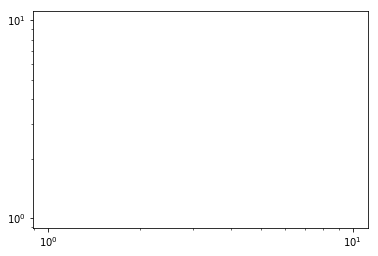

In [12]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(DM[tel], f_p[tel], label='ASKAP')
ax.scatter(DM[tel1], f_p[tel1], label='Parkes')
ax.scatter(DM_C, f_p[CHIME[0]], label='CHIME')
ax.set_title('peak flux vs. DM')
ax.set_xlabel('DM (cm^-3 pc)')
ax.set_ylabel('peak flux (Jy)')
ax.legend()
plt.show()

## Adding CHIME FRBs

In [13]:
import csv

frbC, telescopeC, snrC, f_pC, d_LC, zC = [], [], [], [], [], []

with open('frb.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    chime_lines = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
            continue
        line_count += 1
        if row[1] == 'CHIME/FRB':
            chime_lines += 1
            frbC.append(row[0])
            telescopeC.append(row[1])
            snrC.append(float(row[2]))
            f_pC.append(float(row[3]))
            d_LC.append(float(row[4]))
            zC.append(float(row[5]))
            
    print(f'Processed {chime_lines} lines.')

hide_toggle()

Processed 8 lines.


In [14]:
SETSNR = 6

#Deriving New Parameters
f_limC = []
L_pC = []
L_plimC = []

for i in range(len(f_pC)):
    f_lim_i = f_pC[i]/(SETSNR)
    L_p_i = (f_pC[i]*1e-19)*4*math.pi*(d_LC[i]*3.08567758e25)**2
    L_plim_i = (f_lim_i*1e-19)*4*math.pi*(d_LC[i]*3.08567758e25)**2
    f_limC.append(f_lim_i)
    L_pC.append(L_p_i)
    L_plimC.append(L_plim_i)

hide_toggle()

In [15]:
for i in range(len(f_pC)):
    f_p.append(f_pC[i])
    z.append(zC[i])
    L_p.append(L_pC[i])
    L_plim.append(L_plimC[i])
    d_L.append(d_LC[i])
    snr.append(SETSNR)

hide_toggle()

In [16]:
frbC, tC, DM_C, W_C, snr_C, f_pC = [], [], [], [], [], []

with open('DM_and_fluence.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
            continue
        line_count += 1
        if row[1] == 'CHIME/FRB':
            print(row[0], row[1], float(row[4]))
            frbC.append(row[0])
            tC.append(row[1])
            DM_C.append(float(row[2]))
            W_C.append(float(row[3]))
            snr_C.append(float(row[4]))
            f_pC.append(float(row[5]))
    print(f'Processed {line_count} lines.')
    
hide_toggle()

FRB180908.J1232+74 CHIME/FRB 0.0
FRB190117.J2207+17 CHIME/FRB 0.0
FRB190208.J1855+46 CHIME/FRB 0.0
FRB190212.J18+81 CHIME/FRB 0.0
FRB190303.J1353+48 CHIME/FRB 0.0
FRB190417.J1939+59 CHIME/FRB 0.0
FRB190604.J1435+53 CHIME/FRB 0.0
FRB190907.J08+46 CHIME/FRB 0.0
Processed 64 lines.


In [17]:
for i in range(len(W_C)):
    fluence.append(W_C[i]*f_pC[i])

In [18]:
frbC

['FRB180908.J1232+74',
 'FRB190117.J2207+17',
 'FRB190208.J1855+46',
 'FRB190212.J18+81',
 'FRB190303.J1353+48',
 'FRB190417.J1939+59',
 'FRB190604.J1435+53',
 'FRB190907.J08+46']

## Deriving L_lim (L_p,lim also used) in most recent way, depending on telescope

- $L_{lim} = L_p * F_{lim}/F_p$

In [19]:
L_lim = []
f_lim = [14.8, 0.30, 0.30]
for i in range(len(f_p)):
    if(i < 27): #ASKAP
        L_lim.append(L_p[i] * f_lim[0]/f_p[i])
    elif(i >= 27 and i < 54): #Parkes
        L_lim.append(L_p[i] * f_lim[1]/f_p[i])
    elif(i >= 54): #CHIME
        L_lim.append(L_p[i] * f_lim[2]/f_p[i])

hide_toggle()

In [20]:
print(L_lim)

[1.3101181929463999e+35, 8.648827133122714e+34, 4.4803159315416265e+35, 1.1333202361128027e+34, 2.3419000191549705e+34, 4.091286052367217e+34, 6.325520649091471e+34, 2.181818535804037e+34, 6.325520649091471e+34, 1.4892536227669793e+33, 1.3489344110332629e+35, 3.9117256274580937e+33, 7.713660857042764e+33, 1.951860776645274e+35, 4.533280944451211e+34, 5.865640547031323e+34, 7.5146214905754505e+34, 2.946809695180179e+34, 1.5620163235511594e+35, 4.7882779975765896e+33, 7.083251475705015e+34, 4.364876640616322e+34, 7.297342751558199e+34, 2.5570537827295112e+33, 1.735573692834621e+34, 4.254377917595325e+34, 5.801360039889301e+34, 8.847722920168221e+32, 3.980344626128987e+33, 1.4066332374797521e+34, 3.038140565390232e+32, 7.23783865318155e+32, 7.236438753818953e+33, 1.6113200612047202e+32, 8.132912768712868e+33, 3.908949758636535e+33, 1.2158449017854925e+34, 2.102146314644536e+33, 3.0712535695439704e+34, 7.59535141347558e+33, 1.2418184191899866e+33, 6.483508265874416e+33, 4.39711979277296e+3

# Kendall Tau Graph Functions

## graph presets:
```python
- ASKAP = (slice(0,27), 'ASKAP', 14.8, '#1f77b4')
- PARKES = (slice(27,54), 'Parkes', 0.15, '#ff7f0e')
- CHIME = (slice(54,62), 'CHIME', 0.30, '#2ca02c')
- ALL = (slice(0,62), 'All FRBs', 0.15, '#1f77b4')
```

In [21]:
#Presets for the TELESCOPE option
ASKAP = (slice(0,27), 'ASKAP', 14.8, '#1f77b4')
PARKES = (slice(27,54), 'Parkes', 0.15, '#ff7f0e')
NEW_PARKES = (slice(27,54), 'Parkes', 0.3, '#ff7f0e')
CHIME = (slice(54,62), 'CHIME', 0.30, '#2ca02c')
ALL = (slice(0,62), 'All FRBs', 0.15, '#1f77b4')
hide_toggle()

## new_L, tau_k, tk_graph
```python
- new_L(L, z, k=0, g=g_new)
- tau_k(L_p, z, k, F_lim, d_L, func=L_lim1, g=g_new)
- tkgraph(L_p, z, d_L, func=L_lim1, g=g_new, k_min=0, k_max=10, dk=0.01, TELESCOPE=ALL)
```

In [22]:
def new_L(L, z, k=0, g=g_new):
    return [L[i]/g(z[i], k) for i in range(len(L))]

def tau_k(L_p, z, k, F_lim, d_L, func=L_lim1, g=g_new):
    L_new = new_L(L_p, z, k=k, g=g)
    return kt_newform(L_new, z, F_lim, d_L, g=g, k=k, func=func)

def tkgraph(L_p, z, d_L, func=L_lim1, g=g_new, k_min=0, k_max=10, dk=0.01, TELESCOPE=ALL):
    #the current k value
    k = k_min
    
    #expand telescope
    tel, telname, F_LIM, color = TELESCOPE

    #list of k, tau
    list_k = []
    list_t = []

    k1 = k_min #k closest to tau = 1
    kn1 = k_min #k closest to tau = -1
    k0 = k_min #k closest to t=0

    dif1 = 1e300 #smallest distance so far to tau = 1
    difn1 = 1e300 #smallest distance so far to tau = -1
    dif0 = 1e300

    while(k <= k_max):
        list_k.append(k)
        t_k = tau_k(L_p[tel], z[tel], k, F_LIM, d_L[tel], func=func, g=g)
        list_t.append(t_k)

        if(abs(t_k-1) < dif1):
            dif1 = abs(t_k-1)
            k1 = k
        if(abs(t_k+1) < difn1):
            difn1 = abs(t_k+1)
            kn1 = k
        if(abs(t_k) < dif0):
            dif0 = abs(t_k)
            k0 = k

        k += dk
    
    return list_k, list_t, round(k1,2), round(kn1,2), round(k0,2)

hide_toggle()

## tkplot
```python
tkplot(list_k, list_t, k1, kn1, k0, k_min=0, k_max=10, dk=0.01, TELESCOPE=ALL, PLOT_LINES=True, NAT=False):
```

In [23]:
def tkplot(list_k, list_t, k1, kn1, k0, k_min=0, k_max=10, dk=0.01, TELESCOPE=ALL, PLOT_LINES=True, NAT=False):
    
    #expand telescope
    tel, telname, F_LIM, color = TELESCOPE

    k1, kn1, k0 = round(k1, 2), round(kn1, 2), round(k0, 2)

    YMAX, YMIN = max(list_t), min(list_t)
    XMAX, XMIN = k_max, k_min
    MAR = 0 #margin
    XMAR = MAR/10 * (abs(XMAX)+abs(XMIN)) #scaling the xmargin
    YMAR = MAR/10 * (abs(YMAX)+abs(YMIN)) #scaling the ymargin

    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.plot(list_k, list_t, label='τ(k)')
    ax.plot(list_k, [0 for i in range(len(list_k))], label='τ=0')

    if PLOT_LINES:
        ax.plot([k1 for i in range(11)], [YMIN+(1-YMIN)*i/10 for i in range(11)], color='black', linestyle='--', label='k = ' + str(kn1))
        ax.plot([kn1 for i in range(11)], [YMIN+(-1-YMIN)*i/10 for i in range(11)], color='black', linestyle='--', label='k = ' + str(k1))
        ax.plot([XMIN + (k1-XMIN)*i/10 for i in range(11)],[1 for i in range(11)], color='black', linestyle='--')
        ax.plot([XMIN + (kn1-XMIN)*i/10 for i in range(11)],[-1 for i in range(11)], color='black', linestyle='--')
    
    if not NAT:
        ax.set_ylim([YMIN-YMAR, YMAX+YMAR])
        ax.set_xlim([XMIN-XMAR, XMAX+XMAR])
    ax.set_xlabel('k')  # Add an x-label to the axes.
    ax.set_ylabel('τ')  # Add a y-label to the axes.
    ax.plot()

    ax.set_title(f"[{telname}] Relation between τ and k")  # Add a title to the axes.
    ax.legend()  # Add a legend.
    return fig, ax

hide_toggle()

## tau_k2, tk_graph2
```python
- tau_k2(L_p, L_plim, k, func=L_lim2, g=g_new)
- tk_graph2(L_p, L_lim, func=L_lim2, g=g_new, k_min=0, k_max=10, dk=0.01, TELESCOPE=ALL)
```
- to be used exclusively for L-Llim space
- additionally, can use regular tkplot; no need to use a separate plotter

In [24]:
#this uses the other version of kendall tau, to be used for L-Llim space. 
#Haven't been able to get it working though.

def tau_k2(L_p, L_plim, k, func=L_lim2, g=g_new):
    L_new = new_L(L_p, z, k=k, g=g)
    L_pnew = new_L(L_plim, z, k=k, g=g)
    return kendall_tau(L_new, L_pnew, func=func)

def tk_graph2(L_p, L_lim, func=L_lim2, g=g_new, k_min=0, k_max=10, dk=0.01, TELESCOPE=ALL):
    #the current k value
    k = k_min
    
    #expand telescope
    tel, telname, F_LIM, color = TELESCOPE

    #list of k, tau
    list_k = []
    list_t = []

    k1 = k_min #k closest to tau = 1
    kn1 = k_min #k closest to tau = -1
    k0 = k_min #k closest to t=0

    dif1 = 1e300 #smallest distance so far to tau = 1
    difn1 = 1e300 #smallest distance so far to tau = -1
    dif0 = 1e300

    while(k <= k_max):
        list_k.append(k)
        t_k = tau_k2(L_p[tel], L_lim[tel], k, func=func, g=g)
        list_t.append(t_k)

        if(abs(t_k-1) < dif1):
            dif1 = abs(t_k-1)
            k1 = k
        if(abs(t_k+1) < difn1):
            difn1 = abs(t_k+1)
            kn1 = k
        if(abs(t_k) < dif0):
            dif0 = abs(t_k)
            k0 = k

        k += dk
    
    return list_k, list_t, round(k1,2), round(kn1,2), round(k0,2)

hide_toggle()

# Graph Functions
## graphLz
```python 
graphLz(L, z, d_L, k=0, TELESCOPE=ALL, L_str='L_peak',prev=None)```
- can plot multiple telescopes using two lines:
```python
fig, ax = graphLz(L_p, z, d_L, TELESCOPE=PARKES)
graphLz(L_p, z, d_L, TELESCOPE=ASKAP, prev=(fig,ax))
```

In [25]:
def graphLz(L, z, d_L, k=0, TELESCOPE=ALL, L_str='L_peak', prev=None, s=None):
    tel, telname, F_LIM, color = TELESCOPE

    L_cutoffs = []
    for i in range(len(z)):
        L_cutoffs.append(L_lim1(F_LIM, z[i], d_L[i], g=g_new, k=k))

    fig, ax = plt.subplots()
    if prev:
        plt.close() #closes the window with nothing on it
        fig, ax = prev #continues working on previous fig
    plt.yscale('log')
    ax.scatter(z[tel], new_L(L[tel], z[tel], k=k), label=telname, color=color, s=s)
    ax.plot(sorted(z), sorted(L_cutoffs), color=color, label=f'F_cutoff = {F_LIM} Jy/g(z,k={k})')
    ax.set_ylim([1e31, 1e37])
    ax.set_xlim([-0.05, 2.25])
    ax.set_xlabel('z')
    ax.set_ylabel(L_str)
    ax.set_title(f'[{telname}] {L_str} vs. z (k={k})')
    ax.legend()
    return fig, ax

hide_toggle()

## graphSz
```python
- graphSz(sigma, z_, TELESCOPE=ALL, prev=None)
```

In [26]:
def graphSz(sigma, z_, TELESCOPE=ALL, prev=None):
    tel, telname, F_LIM, color = TELESCOPE
    
    fig, ax = plt.subplots()
    
    if prev:
        plt.close() #closes the window with nothing on it
        fig, ax = prev #continues working on previous fig
    
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim([1, 200])
    plt.xlim([1, 5])
    ax.scatter(1 + np.array(z_), sigma, label=telname)
    ax.set_xlabel('1+z')
    ax.set_ylabel('sigma')
    ax.set_title(f'[{telname}] sigma vs. (1+z)')
    ax.legend()
    
    return fig, ax

hide_toggle()

## graphPL
```python
- graphPL(phi, Lprime, TELESCOPE=ALL, prev=None):
```

In [27]:
def graphPL(phi, Lprime, TELESCOPE=ALL, prev=None, old=False):
    tel, telname, F_LIM, color = TELESCOPE
    
    fig, ax = plt.subplots()
    
    if prev:
        plt.close() #closes the window with nothing on it
        fig, ax = prev #continues working on previous fig
        
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim([1, 200])
    plt.xlim([1e32, 1e36])
    if old:
        plt.xlim([1e25, 1e29])
    ax.scatter(Lprime, phi, label=telname)
    ax.set_xlabel('L\'')
    ax.set_ylabel('phi(L\')')
    ax.set_title('phi(L\') vs L\'')
    ax.legend()
    
    return fig, ax

hide_toggle()

## log-log polynomial fitting

```python
- unpack(args, logz)
- loglogpfit(s_or_p, x, sigma=False, phi=False, order=2, print_coeffs=True, prev=None, TELESCOPE=ALL)
```

In [28]:
def unpack(args, logz):
    poly = np.zeros(len(logz))
    for j in range(len(args)):
        power = len(args)-j-1
        poly += args[j]*(logz**power)
    return poly

def loglogpfit(s_or_p, x, sigma=False, phi=False, Lz=False, order=2, print_coeffs=True, prev=None, TELESCOPE=ALL, old=False):
    tel, telname, F_LIM, color = TELESCOPE
    
    if not (sigma or phi or Lz):
        raise Exception('specify a preset using sigma=True, phi=True, or Lz=True')
    
    logSP = np.log10(s_or_p)
    logx = np.log10(x)
    
    if sigma or Lz:
        logx = np.log10(1 + np.array(x)) #representing 1+z
    
    if Lz:
        logSP = logSP[tel]
        logx = logx[tel]
    
    args = np.polyfit(logx, logSP, order)
    if print_coeffs:
        print(args)
    
    fig, ax = plt.subplots()
    
    if prev:
        plt.close()
        fig, ax = prev
    
    if sigma:
        plt.ylim([0, 2.3])
        plt.xlim([0, 0.7])
        ax.scatter(logx, logSP, label=telname)
        ax.plot(np.linspace(0, 0.7, 50), unpack(args, np.linspace(0, 0.7, 50)), label='best fit')
        ax.set_xlabel('log(1+z)')
        ax.set_ylabel('log(sigma)')
        ax.set_title('log(sigma) vs. log(1+z)')
        ax.legend()
    
    elif phi:
        plt.ylim([0, 2.3])
        plt.xlim([32, 36])
        if old:
            plt.xlim([25, 29])
        ax.scatter(logx, logSP, label=telname)
        if old:
            ax.plot(np.linspace(25, 29, 50), unpack(args, np.linspace(25, 29, 50)), label='best fit')
        else:
            ax.plot(np.linspace(32, 36, 50), unpack(args, np.linspace(32, 36, 50)), label='best fit')
        ax.set_xlabel('log(L\')')
        ax.set_ylabel('log(phi)')
        ax.set_title('log(phi) vs. log(L\')')
        ax.legend()
    
    elif Lz:
        plt.ylim([31, 37])
        plt.xlim([0, 0.7])
        ax.scatter(logx, logSP, label=telname)
        ax.plot(np.linspace(0, 0.7, 50), unpack(args, np.linspace(0, 0.7, 50)), label='best fit')
        ax.set_xlabel('log(1+z)')
        ax.set_ylabel('log(L)')
        ax.set_title('log(L) vs. log(1+z)')
        ax.legend()
        
    return fig, ax, args

hide_toggle()

## L-Llim
```python
- LLlim(L, Llim, z, k=0, TELESCOPE=ALL, prev=None)
```

In [29]:
def LLlim(L, Llim, z, k=0, TELESCOPE=ALL, prev=None):
    tel, telname, F_LIM, color = TELESCOPE
    
    fig, ax = plt.subplots()
    
    if prev:
        plt.close() #closes the window with nothing on it
        fig, ax = prev #continues working on previous fig
        
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim([1e31, 1e37])
    plt.xlim([1e31, 1e37])
    ax.scatter(new_L(Llim[tel],z[tel],k=k), new_L(L[tel],z[tel],k=k), label=telname, color=color)
    ax.plot([1e31, 1e37], [1e31, 1e37], color='black')
    ax.set_xlabel('L_lim\'')
    ax.set_ylabel('L\'')
    ax.set_title('L\' vs. L_lim\'')
    ax.legend()
    
    return fig, ax
hide_toggle()

In [30]:
#essentially an LLlim plot comparing k=0 to k=k for debugging purposes
def LLlim_change(L, Llim, z, k=0, TELESCOPE=ALL, prev=None):
    tel, telname, F_LIM, color = TELESCOPE
    
    fig, ax = plt.subplots()
    if prev:
        plt.close()
        fig, ax = prev
    
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim([1e31, 1e37])
    plt.xlim([1e31, 1e37])
    ax.scatter(Llim[tel], L[tel], label=telname, color='orange')
    Llim_ = new_L(Llim[tel], z[tel], k=k)
    L_ = new_L(L[tel], z[tel], k=k)
    ax.scatter(Llim_, L_, label=telname + f'(k = {k})', color='blue')
    for i in range(len(L_)):
        ax.plot([Llim[tel][i],Llim_[i]], [L[tel][i], L_[i]], color='pink')
    ax.plot([1e31, 1e37], [1e31, 1e37], color='black')
    ax.set_xlabel('L_lim\'')
    ax.set_ylabel('L\'')
    ax.set_title('L\' vs. L_lim\'')
    ax.legend()
    
    return fig, ax
hide_toggle()

## Example Graphs:

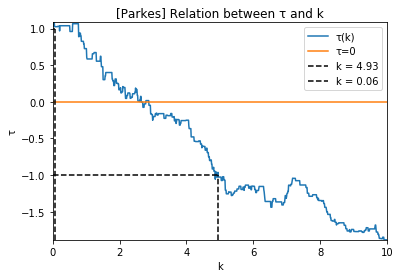

In [31]:
list_k, list_t, k1, kn1, k0 = tkgraph(L_p, z, d_L, TELESCOPE=NEW_PARKES, k_min=0, k_max=10)
fig, ax = tkplot(list_k, list_t, k1, kn1, k0, TELESCOPE=NEW_PARKES, k_min=0, k_max=10)

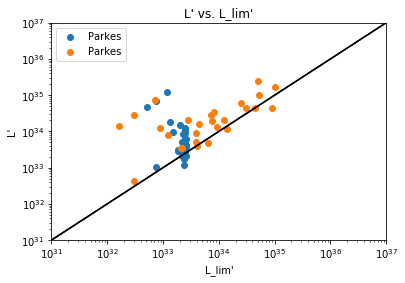

In [32]:
k=7.61
NN_PARKES = (slice(27, 54, None), 'Parkes', 0.3, None)
fig, ax = LLlim(L_p, L_lim, z, k=k, TELESCOPE=NN_PARKES)
fig, ax = LLlim(L_p, L_lim, z, k=0, TELESCOPE=NN_PARKES, prev=(fig,ax))

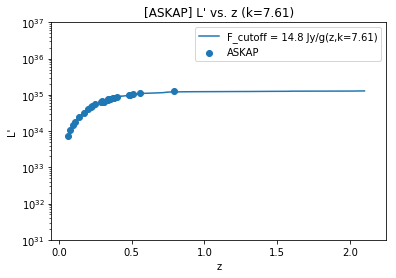

In [33]:
fig, ax = graphLz(L_lim, z, d_L, k=7.61, TELESCOPE=ASKAP, L_str='L\'')
#fig, ax = graphLz(L_p, z, d_L, k=7.61, TELESCOPE=NN_PARKES, prev=(fig,ax), L_str='L\'')

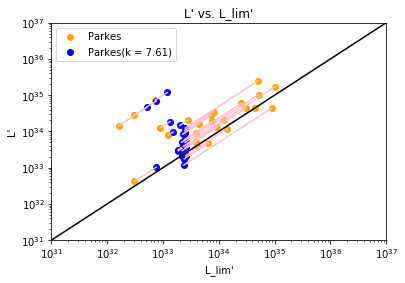

In [34]:
fig, ax = LLlim_change(L_p, L_lim, z, k=k, TELESCOPE=NN_PARKES)

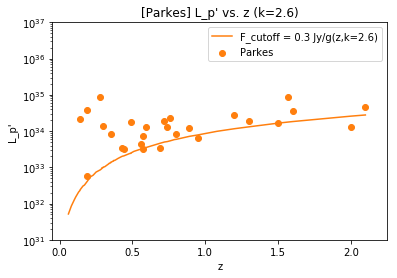

In [35]:
fig, ax = graphLz(L_p, z, d_L, k=k0, TELESCOPE=NEW_PARKES, L_str='L_p\'')

[ 3.16525901 33.4873127 ]


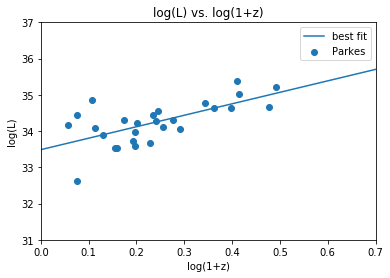

In [36]:
fig, ax, argsLz = loglogpfit(L_p, z, Lz=True, TELESCOPE=NEW_PARKES, order=1)

-1.43


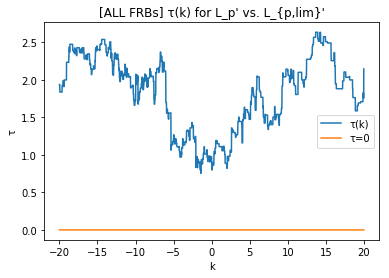

In [37]:
list_k, list_t, k1, kn1, k0 = tk_graph2(L_p, L_lim, TELESCOPE=NEW_PARKES, k_min=-20, k_max=20)
fig, ax = tkplot(list_k, list_t, k1, kn1, k0, TELESCOPE=NEW_PARKES, k_min=-20, k_max=20, NAT=True, PLOT_LINES=False)
ax.set_title('[ALL FRBs] τ(k) for L_p\' vs. L_{p,lim}\'')
print(k0)

In [38]:
L_lim

[1.3101181929463999e+35,
 8.648827133122714e+34,
 4.4803159315416265e+35,
 1.1333202361128027e+34,
 2.3419000191549705e+34,
 4.091286052367217e+34,
 6.325520649091471e+34,
 2.181818535804037e+34,
 6.325520649091471e+34,
 1.4892536227669793e+33,
 1.3489344110332629e+35,
 3.9117256274580937e+33,
 7.713660857042764e+33,
 1.951860776645274e+35,
 4.533280944451211e+34,
 5.865640547031323e+34,
 7.5146214905754505e+34,
 2.946809695180179e+34,
 1.5620163235511594e+35,
 4.7882779975765896e+33,
 7.083251475705015e+34,
 4.364876640616322e+34,
 7.297342751558199e+34,
 2.5570537827295112e+33,
 1.735573692834621e+34,
 4.254377917595325e+34,
 5.801360039889301e+34,
 8.847722920168221e+32,
 3.980344626128987e+33,
 1.4066332374797521e+34,
 3.038140565390232e+32,
 7.23783865318155e+32,
 7.236438753818953e+33,
 1.6113200612047202e+32,
 8.132912768712868e+33,
 3.908949758636535e+33,
 1.2158449017854925e+34,
 2.102146314644536e+33,
 3.0712535695439704e+34,
 7.59535141347558e+33,
 1.2418184191899866e+33,
 6

-1.43
(slice(54, 62, None), 'CHIME', 0.3, '#2ca02c')


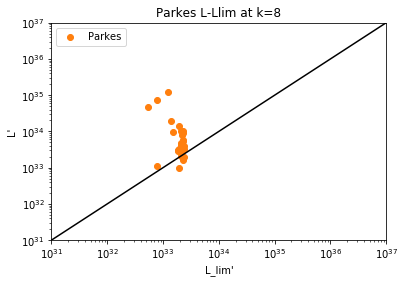

In [39]:
#fig, ax = LLlim(L_p, L_lim, z, k=0, TELESCOPE=(slice(54,62), 'CHIME', 0.3, None))
#fig, ax = LLlim(L_p, L_lim, z, k=1, TELESCOPE=(slice(54,62), 'CHIME_1', 0.3, None), prev=(fig,ax))
#fig, ax = LLlim(L_p, L_lim, z, k=2, TELESCOPE=(slice(54,62), 'CHIME_2', 0.3, None))
#fig, ax = LLlim(L_p, L_lim, z, k=3, TELESCOPE=(slice(54,62), 'CHIME_3', 0.3, None), prev=(fig,ax))
#fig, ax = LLlim(L_p, L_lim, z, k=4, TELESCOPE=(slice(54,62), 'CHIME_4', 0.3, None), prev=(fig,ax))
#fig, ax = LLlim(L_p, L_lim, z, k=5, TELESCOPE=(slice(54,62), 'CHIME_5', 0.3, None), prev=(fig,ax))
#fig, ax = LLlim(L_p, L_lim, z, k=6, TELESCOPE=(slice(54,62), 'CHIME_6', 0.3, None))
# fig, ax = LLlim(L_p, L_lim, z, k=7, TELESCOPE=(slice(54,62), 'CHIME_7', 0.3, None), prev=(fig,ax))
# fig, ax = LLlim(L_p, L_lim, z, k=8, TELESCOPE=(slice(54,62), 'CHIME_8', 0.3, None), prev=(fig,ax))
#fig, ax = LLlim(L_p, L_lim, z, k=9, TELESCOPE=(slice(54,62), 'CHIME_9', 0.3, None))
fig, ax = LLlim(L_p, L_lim, z, k=8, TELESCOPE=NEW_PARKES)
plt.title('Parkes L-Llim at k=8')
print(k0)
print(CHIME)

# Actual LFD stuff

## sigma_z
```python
- sigma_z(L, z, d_L, func=L_lim1, g=g_new, TELESCOPE=ALL)
```

In [40]:
def sigma_z(L, z, d_L, func=L_lim1, g=g_new, TELESCOPE=ALL): #z0 being the z of interest
    
    tel, telname, F_LIM, color = TELESCOPE
    
    z, L, d_L = sort_by_1(z[tel], L[tel], d_L[tel])
    zs_actual = []
    m = []
    for i in range(len(L)):
        num = 0
        
        if(L[i] < func(F_LIM, z[i], d_L[i], g=g)): #skip all those under limit
            print(z[i])
            continue
        
        #if above limit, add to list of indices
        zs_actual.append(z[i])
        
        for j in range(0, i): #since sorted by now, only j < i has z_j < z_i
            if(L[j] >= func(F_LIM, z[i], d_L[i], g=g) and z[j] <= z[i]): #associated set requirements
                num += 1
        
        m.append(num+1) #includes itself?
    
    sigma = []
    prod = 1
    for j in range(len(m)):
        prod *= (1 + 1/m[j])
        sigma.append(prod)
    
    return sigma, zs_actual

hide_toggle()

In [41]:
sigma, z_ = sigma_z(L_p, z, d_L, TELESCOPE=NEW_PARKES)

0.69
0.95
2.0


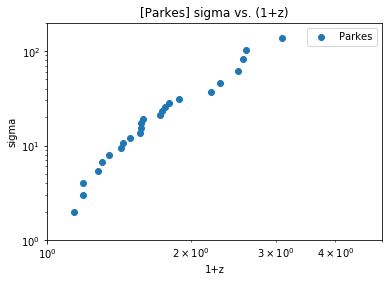

In [42]:
fig, ax = graphSz(sigma, z_, TELESCOPE=NEW_PARKES)

In [43]:
for i in range(len(sigma)):
    print(sigma[i])

2.0
3.0
4.0
5.333333333333333
6.666666666666666
7.999999999999999
9.333333333333332
10.666666666666664
11.999999999999996
13.71428571428571
15.428571428571423
17.14285714285714
19.047619047619044
21.16402116402116
23.28042328042328
25.608465608465607
28.16931216931217
30.73015873015873
36.87619047619047
46.09523809523809
61.46031746031745
81.94708994708992
102.4338624338624
136.57848324514987


## functions for creation of any L_lim
```python
- manual_dL(z, O_M=0.286, O_V=0.714, H_0=69.6, dz = 1e-5)
- manual_Llim(F_lim, z_i, g=g_new, k=0)
- manual_dVdz(z, O_M=0.286, O_V=0.714, H_0=69.6, dz= 1e-5, prev=None)
```

In [44]:
def manual_dL(z, O_M=0.286, O_V=0.714, H_0=69.6, dz = 1e-5, prev=None):
    d_H = 299792458/(H_0*3.24077929e-20) #Hubble Distance, in meters!
    
    #numerical integration
    z_cur = 0
    integral = 0
    
    if prev: #already integrated up to a certain point
        z_cur, d_L = prev #assume format is [z, d_L]
        integral = d_L/(d_H*(1+z_cur))
    
    while(z_cur < z):
        dI = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        z_cur += dz
        dI2 = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        integral += (dI+dI2)/2
    
    return integral*(1+z)*d_H

def manual_Llim(F_lim, z_i, g=g_new, k=0, prev=None):
    if not prev:
        return (F_lim*1e-19)*4*math.pi*(manual_dL(z_i, prev=prev))**2/g(z_i, k)
    d_L = manual_dL(z_i, prev=prev)
    return [(F_lim*1e-19)*4*math.pi*(d_L)**2/g(z_i, k), d_L]

def manual_dVdz(z, O_M=0.286, O_V=0.714, H_0=69.6, dz= 1e-5, prev=None):
    d_H = 299792458/(H_0*3.24077929e-20) #Hubble Distance, in meters!
    
    #numerical integration
    z_cur = 0
    integral = 0
    
    if prev:
        z_cur, integral = prev
    
    while(z_cur < z):
        dI = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        z_cur += dz
        dI2 = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        integral += (dI+dI2)/2
    
    if not prev:
        return 4*math.pi*(d_H**3)*integral**2/(O_M*(1+z_cur)**3 + O_V)**0.5
    return [4*math.pi*(d_H**3)*integral**2/(O_M*(1+z_cur)**3 + O_V)**0.5, integral]

hide_toggle()

## random progress bar function
```python
- print_progress(i, l, prefix='PROGRESS:', suffix='COMPLETE', decimals=1, length=50, fill='█', empty='-')
```

In [45]:
def print_progress(i, l, prefix='PROGRESS:', suffix='COMPLETE', decimals=1, length=50, fill='█', empty='-'):
    blocks = int(i*length/l)
    spaces = length-blocks
    percent = round(100*i/l,decimals)
    bar = blocks*fill + spaces*empty
    print(f"\r{prefix} |{bar}| {percent}% {suffix}", end=' ')
    
    #note; some errors when progress goes too fast

hide_toggle()

## functions for Phi
```python
- get_max_z(zrange, L_cutoffs, L)
- create_Lcutoffs(TELESCOPE=ALL)
- phi_L(L_p, z, k=0, L_cutoffs=None, zrange=None, func=L_lim1, g=g_new, TELESCOPE=ALL)
```

In [123]:
def get_max_z(zrange, L_cutoffs, L):
    idx = np.argwhere(np.diff(np.sign(np.array(L_cutoffs) - L))).flatten()
    if(len(idx) < 1):
        return 1e300
    return np.array(zrange)[idx][0]

def create_Lcutoffs(TELESCOPE=ALL):
    tel, telname, F_LIM, color = TELESCOPE
    
    #creation of the cutoff luminosities
    zrange = np.linspace(0, 2.25, num=2000)
    L_cutoffs = []
    
    prev = (0, 0)

    for i in range(len(zrange)):
        L_lim, d_L = manual_Llim(F_LIM, zrange[i], g=g_new, k=0, prev=prev)
        L_cutoffs.append(L_lim)
        prev = (zrange[i], d_L)
        
    zrange, L_cutoffs = sort_by_first(zrange, L_cutoffs)
    return zrange, L_cutoffs

def phi_L(L_p, z, k=0, L_cutoffs=None, zrange=None, func=L_lim1, g=g_new, TELESCOPE=ALL): #z0 being the z of interest
    
    tel, telname, F_LIM, color = TELESCOPE
    
    #creating the L_cutoffs and zrange if None
    if (not L_cutoffs) or (not zrange):
        zrange, L_cutoffs = create_Lcutoffs(TELESCOPE=TELESCOPE)
    cutoffs_prime = new_L(L_cutoffs, zrange, k=k, g=g_new)
    #####################################
    
    #creation of L_prime
    Lprime = new_L(L_p[tel], z[tel], k=k, g=g_new)
    ####################
    
    Lprime, z = sort_by_first(Lprime, z[tel], reverse=True)
    L_actuals = [] # only return the luminosities that are above the limit
    n = []
    for i in range(len(z)):
        num = 0
        z_max = get_max_z(zrange, cutoffs_prime, Lprime[i])
        
        if (z[i] > z_max): #skip things under limit
            ax.scatter(z[i], Lprime[i])
            print(z[i])
            continue
            
        L_actuals.append(Lprime[i])
        
        for j in range(0, i): #since sorted by largest L' to smallest
                            #should only include L'[j] > L'[i]
                
            if(Lprime[j] >= Lprime[i] and z[j] <= z_max): #associated set requirements
                num += 1
        
        n.append(num+1) #includes itself?
    
    phi = []
    prod = 1
    for l in range(len(n)):
        prod *= (1 + 1/n[l])
        phi.append(prod)
    
    return phi, L_actuals

hide_toggle()

In [124]:
NN_PARKES = (slice(27, 54), 'Parkes', 0.29, 'ff7f0e')
zrange, L_cutoffs = create_Lcutoffs(TELESCOPE=NN_PARKES)
phi, Lprime = phi_L(L_p, z, k=2.6, L_cutoffs=L_cutoffs, zrange=zrange, TELESCOPE=NN_PARKES)


2.0
0.95
0.69


8.763069467615085e+34
8.566404789629308e+34
4.636565880006141e+34
3.805800921445755e+34
3.660143984618289e+34
2.710189915498122e+34
2.3373367899449704e+34
2.1470469643407034e+34
1.898020583529569e+34
1.877181949133352e+34
1.8270155632146417e+34
1.6552653127596186e+34
1.4234988975294123e+34
1.3017328388593384e+34
1.2674029756842977e+34
1.1898168389420905e+34
8.46162971935083e+33
8.274075917797688e+33
7.488413958976006e+33
4.276508089483127e+33
3.368705671644532e+33
3.230350885713167e+33
3.22868263910721e+33
5.653544847075215e+32


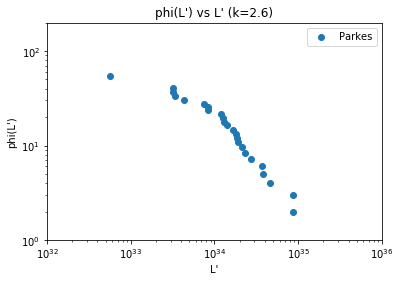

In [127]:
fig, ax = graphPL(phi, Lprime, TELESCOPE=NEW_PARKES)
ax.set_title('phi(L\') vs L\' (k=2.6)')

for i in range(len(phi)):
    print(Lprime[i])

[-7.71506238e+02  9.64070653e+02 -4.06780220e+02  5.91952546e+01
  4.09764416e+00 -8.19452993e-04]


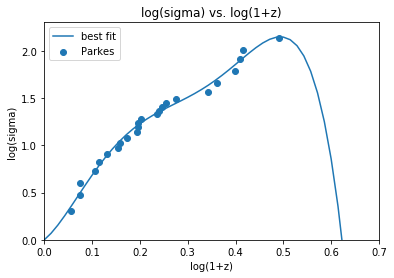

In [45]:
fig, ax, argsSig = loglogpfit(sigma, z_, sigma=True, TELESCOPE=NEW_PARKES, order=5)

[ 6.92133630e-01 -9.42048130e+01  4.80750833e+03 -1.09023621e+05
  9.27027755e+05]


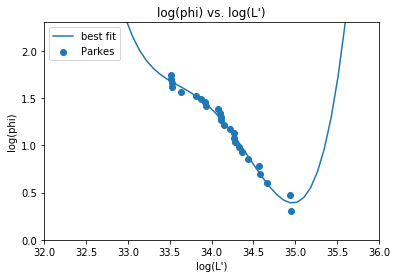

In [72]:
fig, ax, argsPhi = loglogpfit(phi, Lprime, phi=True, TELESCOPE=NEW_PARKES, order=4)

# NEW LF Functions, unique to version 2.0

In [162]:
def derivative(args, logx, phi=False, sigma=False):
    if not (sigma or phi):
        raise Exception('specify a preset using sigma=True or phi=True')
    
    logx = np.array(logx)
    if sigma:
        logx = 1+logx
    
    poly = np.zeros(len(logx))
    for j in range(len(args)):
        n = len(args)-j-1
        if n >= 0:
            poly += n*args[j]*(logx**(n-1))
    return poly

In [163]:
devPhi = derivative(argsPhi, np.log10(Lprime), phi=True)

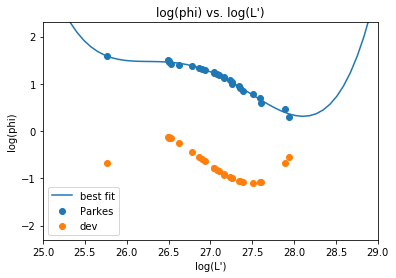

In [164]:
fig, ax = plt.subplots()
plt.ylim([-2.3, 2.3])
plt.xlim([25, 29])
ax.scatter(np.log10(Lprime), np.log10(phi), label='Parkes')
ax.scatter(np.log10(Lprime), devPhi, label='dev')
ax.plot(np.linspace(25, 29, 50), unpack(argsPhi, np.linspace(25, 29, 50)), label='best fit')
ax.set_xlabel('log(L\')')
ax.set_ylabel('log(phi)')
ax.set_title('log(phi) vs. log(L\')')
ax.legend()

In [165]:
def psi_L(phi, Lprime, argsPhi):
    devPhi = derivative(argsPhi, np.log10(Lprime), phi=True)
    return [-phi[i]/Lprime[i] * devPhi[i] for i in range(len(phi))]

In [166]:
psi = psi_L(phi, Lprime, argsPhi)

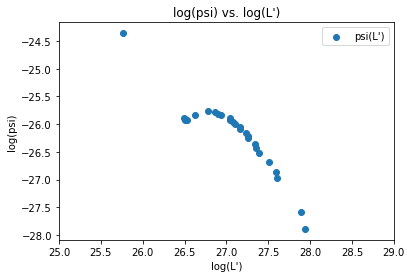

In [167]:
fig, ax = plt.subplots()
#plt.ylim([-2.3, 2.3])
plt.xlim([25, 29])
ax.scatter(np.log10(Lprime), np.log10(psi), label='psi(L\')')
ax.set_xlabel('log(L\')')
ax.set_ylabel('log(psi)')
ax.set_title('log(psi) vs. log(L\')')
ax.legend()

In [168]:
def rho_z(sigma, z_, argsSig):
    devSig = derivative(argsSig, np.log10(z_), sigma=True)
    dSdz = [sigma[i]/z_[i] * devSig[i] for i in range(len(sigma))]
    
    z_cur = 0
    i = 0
    dz = 1e-5
    
    prev = (0, 0)
    
    dVdz = []
    
    while(i < len(z_)):
        dVdzi, integral = manual_dVdz(z_[i], prev=prev)
        prev = (z_[i], integral)
        dVdz.append(dVdzi)
        i += 1
    
    return [(1+z_[i])*dSdz[i]/dVdz[i] for i in range(len(z_))]

In [169]:
rho = rho_z(sigma, z_, argsSig)

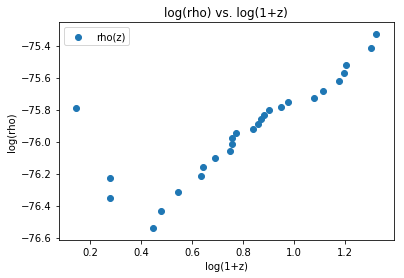

In [170]:
fig, ax = plt.subplots()
#plt.ylim([-2.3, 2.3])
#plt.xlim([0, 0.7])
ax.scatter(1+np.log10(z_), np.log10(rho), label='rho(z)')
ax.set_xlabel('log(1+z)')
ax.set_ylabel('log(rho)')
ax.set_title('log(rho) vs. log(1+z)')
ax.legend()

In [96]:
def fitted_sigma(z, d1=6.4, d2=1.45, Z_c=1.58, n=1.8):
    z = np.array(z)
    Z = 1+z
    num = np.power(z, d1)
    denom = np.power(1 + np.power(Z/Z_c, n*(d2-d1)), 1/n)
    return num/denom

In [99]:
fitted_sigma(z_)

array([6.61797652e-07, 5.70242026e-06, 5.70242026e-06, 9.43540589e-05,
       1.56730602e-04, 4.90609678e-04, 2.27332343e-03, 2.69823304e-03,
       6.00941502e-03, 1.61095435e-02, 1.83416766e-02, 1.83416766e-02,
       2.35993633e-02, 7.29544322e-02, 9.86470891e-02, 1.19647331e-01,
       1.44237210e-01, 2.06096997e-01, 4.28127360e-01, 6.65269638e-01,
       3.12208774e+00, 5.25873455e+00, 1.32731118e+01, 1.78080242e+01,
       2.01155872e+01, 8.42939489e+01, 1.15241585e+02])

In [174]:
z_

[0.14,
 0.19,
 0.19,
 0.28,
 0.3,
 0.35,
 0.43,
 0.44,
 0.49,
 0.56,
 0.57,
 0.57,
 0.59,
 0.69,
 0.72,
 0.74,
 0.76,
 0.8,
 0.89,
 0.95,
 1.2,
 1.3,
 1.5,
 1.57,
 1.6,
 2.0,
 2.1]